## LSTM Modelling

We will start off this notebook by building an Bi-LSTM model using Tensorflow Keras with GloVe embedding.  
As our Airbnb reviews dataset itself is not pre-annotated, it cannot be used to train the model unless we manual annotate / use existing tool to annotate the entire dataset.  

Thus, we will use an existing pre-annotated dataset to train our LSTM NER model and then re-train the model on a small manually-annotated dataset of Airbnb reviews.

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split

In [2]:
# Imports
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# Imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

from seqeval.metrics import classification_report

## Data Import & Cleaning & Preprocessing

This dataset is downloadable from Kaggle. It is from the Groningen Meaning Bank ([GMB](https://gmb.let.rug.nl)), which is developed at the University of Groningen. It comprises of thousands of texts in raw and tokenised format, tags for part of speech, named entities and lexical categories.

Source: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [4]:
# Read csv
data = pd.read_csv('../data/ner_dataset.csv')

In [5]:
# Check df
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [6]:
# Check data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [7]:
# Check for null values
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [8]:
# For our null values, we will use forward-fill method because the words are from the same sentence
data.fillna(method='ffill', inplace=True)

In [9]:
# Check df
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [10]:
#Make all column names lowercase
#Replace all space with non-space
data.columns = data.columns.str.lower().str.replace(' ','')

In [11]:
# Check number of tag types
n_tag = data['tag'].nunique()
n_tag

17

In [12]:
# Check amount of unique words
data['word'].nunique()

35172

In [13]:
# Observe the most frequently used words
data['word'].value_counts()[0:30]

the     52573
.       47761
,       32754
of      26354
in      26323
to      23213
a       20481
and     19936
The     11313
's      10923
for      8498
has      7216
is       6746
on       6710
that     6301
have     5485
with     5381
said     5321
was      4878
says     4640
from     4539
by       4482
at       4343
say      4178
U.S.     4129
as       4106
an       3845
are      3718
"        3686
were     3519
Name: word, dtype: int64

Most of the words within the corpus are stopwords. However, it might not be wise to remove them from our dataset, as we might lose some context when the model learns through the sequence of words.

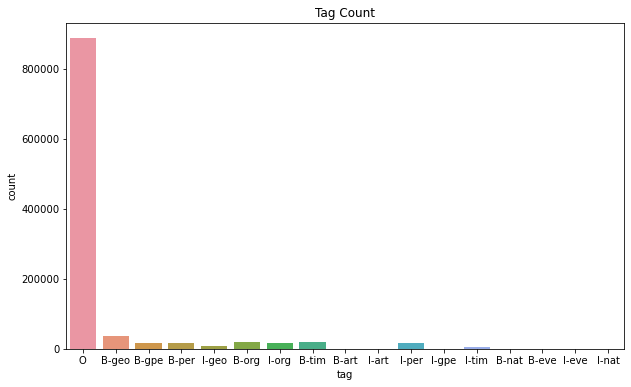

In [14]:
# Observe the distribution of tags
fig = plt.figure(figsize=(10,6))
sns.countplot(data=data, x='tag')
plt.title('Tag Count');

- Most of the tags are 'O', so we can deduce that our dataset is not very rich in named entities
- The second highest count is 'geo' for geographical entity. Because the 'B' format is much higher than 'I', it is very likely that most of the 'geo' entities are of single-words
- Same goes for 'gpe' or geopolitical entities
- However, 'per' or person and 'org' for organization are likelier to have more than one word in the entities
- The art, event and nature categories are almost non-existent
- **Due to the imbalanced classes, we will need to use other metrics (not accuracy) when we perform modelling**

Before we start modelling, we need to process our data into numbers that our model can take in.  
For the words, we will use the Keras tokenizer and text-to-sequence function.  
However, we will manually change our tags into numbers so that we can apply the Keras to-categorical function.  

In [15]:
# Tokenize labels into numerics
vocab = list(set(data['tag'].to_list()))

# Create dictionary of each tokens
tag_idx = {tag:idx for  idx, tag in enumerate(vocab)}
idx_tag = {idx:tag for  idx, tag in enumerate(vocab)}

# Use map function to get the converted labels
data['tag_idx'] = data['tag'].map(tag_idx)

In [16]:
# Check dictionary of tags
tag_idx

{'O': 0,
 'B-gpe': 1,
 'B-art': 2,
 'B-eve': 3,
 'I-geo': 4,
 'I-org': 5,
 'B-tim': 6,
 'I-nat': 7,
 'I-art': 8,
 'I-eve': 9,
 'B-org': 10,
 'I-per': 11,
 'I-gpe': 12,
 'B-nat': 13,
 'I-tim': 14,
 'B-per': 15,
 'B-geo': 16}

In [17]:
# Convert the data into a list format (reason: to merge them together using groupby function)
data['word'] = [[tok] for tok in data['word']]
data['pos'] = [[tok] for tok in data['pos']]
data['tag'] = [[tok] for tok in data['tag']]
data['tag_idx'] = [[tok] for tok in data['tag_idx']]

In [18]:
# Check df
data

,sentence#,word,pos,tag,tag_idx
0,Sentence: 1,[Thousands],[NNS],[O],[0]
1,Sentence: 1,[of],[IN],[O],[0]
2,Sentence: 1,[demonstrators],[NNS],[O],[0]
3,Sentence: 1,[have],[VBP],[O],[0]
4,Sentence: 1,[marched],[VBN],[O],[0]
...,...,...,...,...,...
1048570,Sentence: 47959,[they],[PRP],[O],[0]
1048571,Sentence: 47959,[responded],[VBD],[O],[0]
1048572,Sentence: 47959,[to],[TO],[O],[0]
1048573,Sentence: 47959,[the],[DT],[O],[0]


In [19]:
# Merge the data together using the groupby function (grouped by 'sentence#')
data = data.groupby('sentence#').agg({'word':'sum','pos':'sum',
                                      'tag':'sum','tag_idx':'sum'}).reset_index()

In [20]:
# Check df
data

,sentence#,word,pos,tag,tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 16, 0, 0..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[0, 0, 6, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 10..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[16, 0, 0, 15, 11, 0, 6, 0, 16, 0, 1, 0, 1, 0,..."
...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[0, 0, 0, 15, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 10, 5, 0,..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[0, 16, 0, 0, 6, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
# Compute the length of each sentence to know the maximum length
data['len'] = [len(sent) for sent in data['tag']]

In [22]:
# Check df
data

,sentence#,word,pos,tag,tag_idx,len
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 16, 0, 0...",24
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",25
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[0, 0, 6, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 10...",32
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[16, 0, 0, 15, 11, 0, 6, 0, 16, 0, 1, 0, 1, 0,...",35
...,...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[0, 0, 0, 15, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",32
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 10, 5, 0,...",25
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[0, 16, 0, 0, 6, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0...",27
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21


<Figure size 720x432 with 0 Axes>

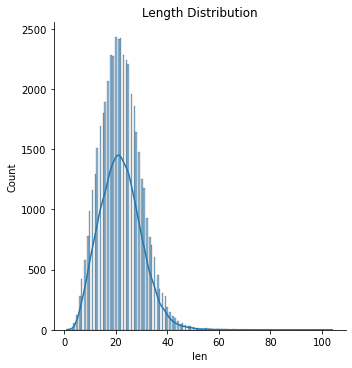

In [23]:
# Plot and observe the distribution of the length of words per sentence
fig = plt.figure(figsize=(10,6))
sns.displot(data=data, x='len', kde=True)
plt.title('Length Distribution');

As observed from our distribution curve above, most of the sentences have a length of around 15 to 30 words.  
Almost all of the sentences lie within the region below 60 words.

One consideration was to truncate sentences to a max of 60 as suggested above, but we decided not to proceed because the gap to the max length is not very far. Hence, the amount of padding that needs to be applied to the sentences is not too big (let's say 1000 words, then it would be too computational expensive).

Another reason is because we are going to apply this model onto our Airbnb dataset, which at this point we may not know the distribution of words in it. Hence, we will proceed with the max length.

In [24]:
# Check max length
max_len = max(data['len'])
max_len

104

We will use max length of 104 to build our LSTM model

In [25]:
# Set labels
labels = data['tag_idx'].tolist()

# Check type of data in list
type(labels[0][0])

int

In [26]:
# Set docs - these are our features
docs = data['word'].tolist()

In [27]:
# Manually slice train-test set to 80-20 size
training_sentences = docs[0:38400]
testing_sentences = docs[38400:]

training_labels = labels[0:38400]
testing_labels = labels[38400:]

In [28]:
# Instantiate Keras Tokenizer, set untrained words as 'OOV' Out of Vocabulary
tokenizer = Tokenizer(oov_token='<OOV>') 
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

In [29]:
# Check the num of words in our word index
n_words = len(tokenizer.word_index)+1
n_words

28824

Our word_index only has 28K words, but our dataset has more than 30K of words.  
Thus, there are a few thousand words that our model will need to learn by itself.  
This may not be helpful in increasing the accuracy of our model.

In [30]:
# Set parameters of the text-to-sequence function
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [31]:
# Convert our words into sequences (list of numbers)
# Then pad the sequences to the exact length of max length (104)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type) #,value=word_index['<OOV>']

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [32]:
# Pad labels so that dimension is the same as input
train_labels_pad = pad_sequences(sequences=training_labels, maxlen=max_len, padding=padding_type, 
                                 truncating=trunc_type, value=tag_idx.get('O'))
test_labels_pad = pad_sequences(sequences=testing_labels, maxlen=max_len, padding=padding_type, 
                                truncating=trunc_type, value=tag_idx.get('O'))

train_labels_padded = [to_categorical(i, num_classes=n_tag) for i in train_labels_pad]
test_labels_padded = [to_categorical(i, num_classes=n_tag) for i in test_labels_pad]

In [33]:
# Check shape
training_padded.shape

(38400, 104)

In [34]:
# Check shape
len(test_labels_padded)

9559

In [35]:
# Convert lists to array before feeding into model
training_padded = np.array(training_padded)
training_labels = np.array(train_labels_padded)
testing_padded = np.array(testing_padded)
testing_labels = np.array(test_labels_padded)

## GloVe Embedding, Bi-LSTM Modelling & Prediction

For our word embedding, we will utilize the GloVe (Global Vectors for Word Representation) embedding from [Stanford](https://nlp.stanford.edu/projects/glove/). We will be using their pre-trained word vectors of 50D and 100D dimension size.  
The general intuition on GloVe is that GloVe focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

In [36]:
# Set num of features in embedding (word embedding size)
output_dim = 100

In [37]:
# After downloading the embedding txt file, we will load using below code
embeddings_index = {}
f = open('../data/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [38]:
print('Found %s unique tokens.' % len(word_index))

Found 28823 unique tokens.


The GloVe embedding has a total of 400,000 words, while our training dataset only uses 28,000 words.  
We will need to extract out the vectors of each word inside our training dataset from GloVe.

In [40]:
# Set dimension size
embedding_dim = 100

# If there is any unknown elements, we will input all zeros for that word in the embedding
unknown_element = [0]*100

# First create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((n_words, embedding_dim))

# For each word in our tokenizer, we will map that word out of GloVe
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # If found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # If doesn't exist, assign a zeros vector
        embedding_matrix[i] = unknown_element

In [41]:
# Check matrix
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02767   ,  0.055429  ,  0.0048339 , ...,  0.49401999,
        -0.83863002, -0.59442002],
       [ 0.010828  , -0.20599   , -0.52205998, ...,  0.35444   ,
        -0.36763   , -0.31011999]])

We will now create an LSTM model which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM) layer. A time-distributed dense layer will be used on top to perform multi-class tag classification.

In [42]:
# Create sequential
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=n_words, output_dim=output_dim, input_length=max_len, 
                    embeddings_initializer=Constant(embedding_matrix), trainable=True))

# Add bidirectional LSTM
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.0, recurrent_dropout=0.0), 
                        merge_mode = 'concat'))

# Add timeDistributed Layer
model.add(TimeDistributed(Dense(17, activation="softmax")))

#model.add(Dense(32, activation="relu"))

In [43]:
# Due to the imbalanced class, we will optimize our model using recall
recall = Recall()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[recall])

In [44]:
# Check model topology
model.summary(line_length=90)

Model: "sequential"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 104, 100)                    2882400       
__________________________________________________________________________________________
bidirectional (Bidirectional)           (None, 104, 200)                    160800        
__________________________________________________________________________________________
time_distributed (TimeDistributed)      (None, 104, 17)                     3417          
Total params: 3,046,617
Trainable params: 3,046,617
Non-trainable params: 0
__________________________________________________________________________________________


In [45]:
# Fit and train model
num_epochs = 8
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, validation_data=(testing_padded, testing_labels),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/8
1200/1200 [==============================] - 212s 175ms/step - loss: 0.2043 - recall: 0.9276 - val_loss: 0.0328 - val_recall: 0.9878
Epoch 2/8
1200/1200 [==============================] - 213s 178ms/step - loss: 0.0269 - recall: 0.9904 - val_loss: 0.0276 - val_recall: 0.9902
Epoch 3/8
1200/1200 [==============================] - 212s 177ms/step - loss: 0.0210 - recall: 0.9924 - val_loss: 0.0266 - val_recall: 0.9909
Epoch 4/8
1200/1200 [==============================] - 214s 178ms/step - loss: 0.0177 - recall: 0.9935 - val_loss: 0.0271 - val_recall: 0.9908
Epoch 5/8
1200/1200 [==============================] - 213s 178ms/step - loss: 0.0153 - recall: 0.9944 - val_loss: 0.0273 - val_recall: 0.9914
Epoch 6/8
1200/1200 [==============================] - 214s 178ms/step - loss: 0.0131 - recall: 0.9952 - val_loss: 0.0280 - val_recall: 0.9913


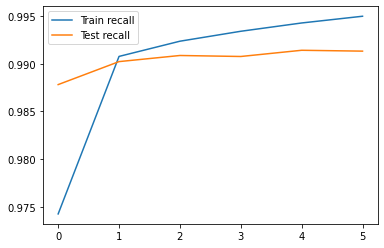

In [46]:
# Check recall curve
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.legend()

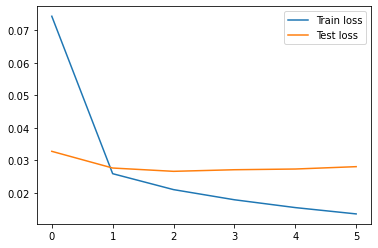

In [47]:
# Check loss curve
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend()

In [48]:
# Find the most probable tags with argmax.
pred_labels = np.argmax(model.predict(testing_padded), axis=-1)

In [49]:
# Check testing label shape
test_labels_pad.shape

(9559, 104)

In [50]:
# Check predicted label shape
pred_labels.shape

(9559, 104)

In [51]:
# Create temp df
temp_df = pd.DataFrame()

# Number the labels
temp_df['num'] = [i for i in range(len(pred_labels))]

# Get model predicted labels
# Then convert back to original tag
temp_df['pred_labels'] = pred_labels.tolist()
temp_df['pred_labels'] = temp_df['pred_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Get model test labels
# Then convert back to original tag
temp_df['test_labels'] = test_labels_pad.tolist()
temp_df['test_labels'] = temp_df['test_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Check df
temp_df

,num,pred_labels,test_labels
0,0,"[B-org, O, O, O, O, O, O, O, O, O, O, O, B-gpe...","[B-org, O, O, O, O, O, O, O, O, O, O, O, B-gpe..."
1,1,"[O, O, O, O, O, O, O, O, O, O, O, B-org, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, B-org, O, O,..."
2,2,"[O, B-gpe, I-gpe, O, O, B-org, I-org, O, B-tim...","[O, B-gpe, I-gpe, O, O, B-org, I-org, O, B-tim..."
3,3,"[O, O, O, O, O, O, O, B-geo, O, O, O, O, B-geo...","[O, O, O, O, O, O, O, B-geo, O, O, O, O, B-geo..."
4,4,"[O, O, O, O, B-tim, I-tim, O, O, O, O, O, O, O...","[O, O, O, O, B-tim, I-tim, O, O, O, O, O, O, O..."
...,...,...,...
9554,9554,"[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
9555,9555,"[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, O...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
9556,9556,"[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
9557,9557,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [52]:
# Check model performance
print(classification_report(temp_df['test_labels'], temp_df['pred_labels'], zero_division=0))

              precision    recall  f1-score   support

         art       0.09      0.01      0.02        83
         eve       0.43      0.29      0.35        68
         geo       0.81      0.87      0.84      7461
         gpe       0.96      0.92      0.94      3369
         nat       0.62      0.33      0.43        39
         org       0.58      0.58      0.58      3997
         per       0.70      0.70      0.70      3314
         tim       0.88      0.86      0.87      4064

   micro avg       0.79      0.79      0.79     22395
   macro avg       0.64      0.57      0.59     22395
weighted avg       0.79      0.79      0.79     22395



The seqeval package very conveniently helps us to analyse our model results down to the entity-level. Hence we can straight away observe the precision, recall and f1-score for each separate class.  
As we already know that we have imbalanced classes, we will choose f1-score as our evaluation metric.

Next, we will need to pick either micro or macro score:  
macro - takes an average of all f1s for individual classes (treating all classes equally)  
micro - aggregate the contributions of all classes' precision and recall to compute the average metric  

Since we have much more examples of (geo, gpe, org, per and tim) than (art, eve, nat), we will use micro-avg score.

Hence, our model is able to reach an f1-score of 0.79!

In [53]:
# Check what are the distribution of misclassified tags

# Create temp df
cdf = temp_df[['num','test_labels','pred_labels']]

# Un-nest the list to compare the tag by each individual word
cdf = cdf.apply(pd.Series.explode)

# If predicted and test tag is different, then label them apart
cdf = cdf[cdf['test_labels']!=cdf['pred_labels']]
cdf['change'] = cdf['test_labels']+' '+cdf['pred_labels']

# Check top10 misclassified tag direction
pd.set_option('display.max_rows', 200)
cdf['change'].value_counts()[0:10]

I-org O        683
B-org O        635
B-org B-geo    497
O I-org        483
O B-org        389
B-tim O        301
B-geo O        299
B-per O        273
B-geo B-org    259
O B-geo        256
Name: change, dtype: int64

Our model seems to misclassify a lot of 'org' tags are 'O' and vice versa, 'O' tags into 'org'.  
Let's look at some misclassified words by our mode below.

In [54]:
# Check tags to see weakness
ct = pd.DataFrame()
ct['sentence'] = testing_sentences[0]
ct['test'] = temp_df['test_labels'][0][0:len(testing_sentences[0])]
ct['pred'] = temp_df['pred_labels'][0][0:len(testing_sentences[0])]

ct

,sentence,test,pred
0,Turkey,B-org,B-org
1,is,O,O
2,the,O,O
3,only,O,O
4,country,O,O
5,that,O,O
6,recognizes,O,O
7,the,O,O
8,government,O,O
9,of,O,O


Misclassification of B-org to B-geo was 3rd on the list.  
As seen above, our model misclassified Cyprus as B-geo instead of B-org.

In [55]:
# Check tags to see weakness
i = 999
ct = pd.DataFrame()
ct['sentence'] = testing_sentences[i]
ct['test'] = temp_df['test_labels'][i][0:len(testing_sentences[i])]
ct['pred'] = temp_df['pred_labels'][i][0:len(testing_sentences[i])]

ct

,sentence,test,pred
0,Meanwhile,O,O
1,",",O,O
2,a,O,O
3,Vatican,B-org,B-org
4,spokesman,O,O
5,says,O,O
6,kidnappers,O,O
7,have,O,O
8,freed,O,O
9,the,O,O


Over here we can see other types of misclassification, such as the model not recognising the archbishop's first name Basile (perhaps its not in the training embedding) and the model did not recognise Catholic Church as an organization, but a person.

## Retrain Using Annotated Samples of Airbnb Review Dataset

Now that our model has been pre-trained, we will now use a small sample size (125rows of dataset) from our Airbnb reviews to retrain our model.  

This is the 'bootstrapping' method, and will allow our model to learn about our Airbnb corpus (without training / learning from the entire corpus).

**Please refer to the notebook 'manual_sampled_annotation' within the 'support' folder.  
The code on the sample extraction and preprocessing done are within**

In [57]:
# Read csv
data_sample = pd.read_csv('../data/manual_annotate_sample.csv')
data_sample.drop(columns='Unnamed: 0', inplace=True)

# Use map to change the labels as done above
data_sample['tag_idx'] = data_sample['tag'].map(tag_idx)

In [58]:
# Check df
data_sample

,num,sentence,tag,tag_idx
0,1,You,O,0
1,1,can,O,0
2,1,walk,O,0
3,1,to,O,0
4,1,the,O,0
...,...,...,...,...
8200,125,.,O,0
8201,125,Would,O,0
8202,125,stay,O,0
8203,125,here,O,0


In [59]:
# Check tag types
data_sample['tag_idx'].unique()

array([ 0, 16,  4,  6, 14,  1, 10,  5, 15, 12,  3,  9])

In [60]:
# Convert all entries into list type
data_sample['sentence'] = [[tok] for tok in data_sample['sentence']]
data_sample['tag'] = [[tok] for tok in data_sample['tag']]
data_sample['tag_idx'] = [[tok] for tok in data_sample['tag_idx']]

In [61]:
# Using groupby function, agg sum all up by id num
data_sample = data_sample.groupby('num').agg({'sentence':'sum',
                                              'tag':'sum','tag_idx':'sum'}).reset_index()

In [62]:
# Check shape of sample
data_sample.shape

(125, 4)

In [63]:
# Repeat what had been done above for first model training

# Assign labels and docs
docs_sample = data_sample['sentence'].tolist()
labels_sample = data_sample['tag_idx'].tolist()

# Manually slice train-test set
training_sentences_sample = docs_sample[0:105]
testing_sentences_sample = docs_sample[105:]

training_labels_sample = labels_sample[0:105]
testing_labels_sample = labels_sample[105:]

# Change list to sequences and pad words
training_sequences_sample = tokenizer.texts_to_sequences(training_sentences_sample)
training_padded_sample = pad_sequences(training_sequences_sample, maxlen=max_len, padding=padding_type, truncating=trunc_type, value=n_words - 1)

testing_sequences_sample = tokenizer.texts_to_sequences(testing_sentences_sample)
testing_padded_sample = pad_sequences(testing_sequences_sample, maxlen=max_len, padding=padding_type, truncating=trunc_type, value=n_words - 1)

# Pad labels so that dimension is the same as input
train_labels_pad_sample = pad_sequences(sequences=training_labels_sample, maxlen=max_len, padding=padding_type, 
                                 truncating=trunc_type, value=tag_idx.get('O'))
test_labels_pad_sample = pad_sequences(sequences=testing_labels_sample, maxlen=max_len, padding=padding_type, 
                                truncating=trunc_type, value=tag_idx.get('O'))

train_labels_padded_sample = [to_categorical(i, num_classes=n_tag) for i in train_labels_pad_sample]
test_labels_padded_sample = [to_categorical(i, num_classes=n_tag) for i in test_labels_pad_sample]

In [64]:
# Convert to array
training_padded_sample = np.array(training_padded_sample)
training_labels_sample = np.array(train_labels_padded_sample)
testing_padded_sample = np.array(testing_padded_sample)
testing_labels_sample = np.array(test_labels_padded_sample)

In [65]:
# Re-train model
num_epochs = 40
history = model.fit(training_padded_sample, training_labels_sample, verbose=0,
            epochs=num_epochs, validation_data=(testing_padded_sample, testing_labels_sample))

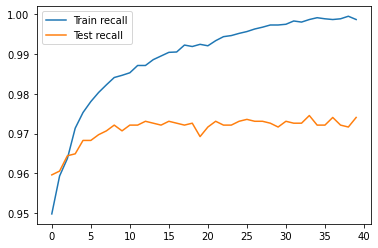

In [66]:
# Check recall curve
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.legend()

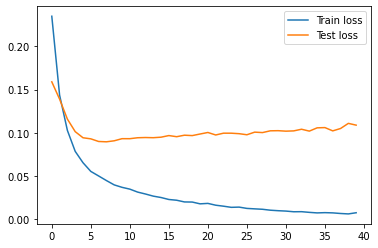

In [67]:
# Check loss curve
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend()

In [68]:
# Use argmax to run predictions in multi-class output
pred_labels_sample = np.argmax(model.predict(testing_padded_sample), axis=-1)

# Get predicted labels and convert to original tag
temp_df_sample = pd.DataFrame()
temp_df_sample['pred_labels'] = pred_labels_sample.tolist()
temp_df_sample['pred_labels'] = temp_df_sample['pred_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Get test labels and convert to original tag
temp_df_sample['test_labels'] = test_labels_pad_sample.tolist()
temp_df_sample['test_labels'] = temp_df_sample['test_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Check df
temp_df_sample

,pred_labels,test_labels
0,"[O, O, O, O, O, O, O, O, I-org, I-org, O, O, O...","[O, O, O, O, O, O, O, B-geo, I-geo, I-geo, O, ..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-tim, I-..."
5,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
7,"[O, O, O, O, O, O, O, O, B-gpe, I-gpe, O, B-ge...","[O, O, O, O, O, O, O, O, B-gpe, I-gpe, O, B-ge..."
8,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,"[O, O, O, O, O, O, O, O, O, O, B-geo, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, B-geo, O, O, O,..."


In [69]:
# Check classification report
print(classification_report(temp_df_sample['test_labels'], 
                            temp_df_sample['pred_labels'], zero_division=0))

              precision    recall  f1-score   support

         eve       0.00      0.00      0.00         1
         geo       0.56      0.68      0.61        22
         gpe       0.33      0.67      0.44         6
         org       0.00      0.00      0.00         6
         per       0.50      0.50      0.50         2
         tim       0.33      0.25      0.29         4

   micro avg       0.44      0.51      0.47        41
   macro avg       0.29      0.35      0.31        41
weighted avg       0.40      0.51      0.45        41



Our re-training f1 score is only able to go to 0.47. This is due to our small training size.  
As can see from above, the amount of weights/support that each class gets is very limited.  
Thus, it is very hard for us to get any conclusion from this value.

## Predict on Airbnb Dataset

Now that our model has been pre-trained and re-trained, we will now use our model to predict on the entire Airbnb dataset and compare the results to the other NER models.

In [70]:
# Read csv
review = pd.read_csv('../data/cleaned_review.csv', low_memory=False, keep_default_na=False)
# Drop column due to re-run purpose
review = review.drop(columns=['lstm'])

In [71]:
# Check df
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk,spacy,spacy_retrain
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...,22,en,Fran was absolutely gracious and welcoming. Ma...,['Fran'],['Fran'],['Would']
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...,39,en,A comfortable room in a smart condo developmen...,['Sujatha'],['Sujatha'],"['Everything', 'Sujatha']"
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...,71,en,Stayed over at Sujatha's house for 3 good nigh...,"['Good', 'Sujatha']","['A few minutes', '3', 'Sujatha']","['Highly', 'Stayed', 'Sujatha']"
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...,42,en,It's been a lovely stay at Sujatha's. The room...,"['Singapore', 'Sujatha']","['the day', 'Singapore', 'Sujatha']","['Thank', 'Singapore', 'Sujatha']"
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am...",17,en,"We had a great experience. A nice place, an am...",[],[],[]


In [72]:
# Create temp df
temp_review = review[['id','re_comments']].copy()

# Segment reviews into multiple sentences
temp_review['re_comments'] = temp_review['re_comments'].map(lambda x: x.split('.'))
# Un-nest the segments into their own rows
temp_review = temp_review.explode('re_comments')

# Add space in front of commas
temp_review['re_comments'] = temp_review['re_comments'].map(lambda x: x.replace(',',' ,'))

# Tokenize each words in each segments via split on whitespace
temp_review['re_comments'] = temp_review['re_comments'].map(lambda x: x.split())

In [77]:
# Check df
temp_review

,id,re_comments
0,8243238,"[Fran, was, absolutely, gracious, and, welcoming]"
0,8243238,"[Made, my, stay, a, great, experience]"
0,8243238,"[Would, definitely, recommend, this, cozy, and..."
0,8243238,[]
1,11909864,"[A, comfortable, room, in, a, smart, condo, de..."
...,...,...
42221,730449201,[]
42222,734174491,"[Beautiful, and, cozy, apartment]"
42222,734174491,"[Great, location]"
42222,734174491,"[However, ,, a, little, too, expensive, for, i..."


In [78]:
# Similar steps when we run our modelling
# Define segments into a list so model can predict
to_pred_rev = temp_review['re_comments'].tolist()

# Convert segments into sequences of numbers then pad to model max length
pred_rev_sequences = tokenizer.texts_to_sequences(to_pred_rev)
pred_rev_sequences_padded = pad_sequences(pred_rev_sequences, maxlen=max_len, 
                                          padding=padding_type, truncating=trunc_type, value=n_words - 1)

# Convert into array
pred_rev = np.array(pred_rev_sequences_padded)

In [79]:
# Use argmax to compute predictions
predicted_rev = np.argmax(model.predict(pred_rev), axis=-1)

In [80]:
# Add the predictions into temp df
temp_review['predicted_array'] = predicted_rev.tolist()

In [81]:
# Convert the tags from numeric to original labels
temp_review['idx_tags'] = temp_review['predicted_array'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

In [82]:
# Check df
temp_review

,id,re_comments,predicted_array,idx_tags
0,8243238,"[Fran, was, absolutely, gracious, and, welcoming]","[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
0,8243238,"[Made, my, stay, a, great, experience]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
0,8243238,"[Would, definitely, recommend, this, cozy, and...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
0,8243238,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,11909864,"[A, comfortable, room, in, a, smart, condo, de...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
42221,730449201,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
42222,734174491,"[Beautiful, and, cozy, apartment]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
42222,734174491,"[Great, location]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
42222,734174491,"[However, ,, a, little, too, expensive, for, i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### Extract Entity from Bi-LSTM Predictions

In order to extract the entities out from the predicted labels, we need to create a function that can merge words together if they are in the same tag, rather than giving us mutliple separated words.

Example:-

Sentence:   I    love    New    York  
    Tags:   O     O     B-geo   I-geo  
    
Extracted entity: New York   (NOT 'New', 'York' which is 2 separate words)

In [83]:
# Function to extract entity our based on tags
def extract_entity(word,tag):
    named_entities = []
    temp_entity_name = ''
    temp_named_entity = None
    temp_tag = None
    for term, tag in zip(word,tag):
        if tag != 'O':
            if temp_tag == None:
                temp_entity_name = ' '.join([temp_entity_name, term]).strip()
                temp_named_entity = temp_entity_name
                temp_tag = tag[2:]
            elif (temp_tag != None) & (tag[2:] == temp_tag):
                temp_entity_name = ' '.join([temp_entity_name, term]).strip()
                temp_named_entity = temp_entity_name
                temp_tag = tag[2:]
            elif (temp_tag != None) & (tag[2:] != temp_tag):
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
                temp_entity_name = ' '.join([temp_entity_name, term]).strip()
                temp_named_entity = temp_entity_name
                temp_tag = tag[2:]
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
                temp_tag = None
    if temp_named_entity != None:
        named_entities.append(temp_named_entity)

    named_entities = list(set(named_entities))

    return (named_entities)

In [84]:
# Run function on the tags and words columns
extracts = []
for splits, tags in zip(temp_review['re_comments'], temp_review['idx_tags']):
    extracts.append(extract_entity(splits,tags))
temp_review['extracted'] = extracts

In [86]:
# Check df
temp_review

,id,re_comments,predicted_array,idx_tags,extracted
0,8243238,"[Fran, was, absolutely, gracious, and, welcoming]","[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,...",[Fran]
0,8243238,"[Made, my, stay, a, great, experience]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
0,8243238,"[Would, definitely, recommend, this, cozy, and...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
0,8243238,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
1,11909864,"[A, comfortable, room, in, a, smart, condo, de...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
...,...,...,...,...,...
42221,730449201,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42222,734174491,"[Beautiful, and, cozy, apartment]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42222,734174491,"[Great, location]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42222,734174491,"[However, ,, a, little, too, expensive, for, i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]


In [87]:
# Because we segmented each review, we need to merge them back in order to get the original review
temp_review = temp_review.groupby('id').agg({'re_comments':'sum','predicted_array':'sum',
                                      'idx_tags':'sum','extracted':'sum'}).reset_index()

In [88]:
# Check df
temp_review

,id,re_comments,predicted_array,idx_tags,extracted
0,251467,"[I, stayed, at, Belinda's, place, for, 4, nigh...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Simei, Jalan Pelatok, Simei Street, cannot, B..."
1,286886,"[A, wonderful, house, with, all, the, amenitie...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
2,298698,"[This, is, a, great, place, with, great, peopl...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[Singapore]
3,333890,"[Fran, is, an, excellent, host, who, provided,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
4,352553,"[Fran, and, family, were, absolutely, fabulous...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...",[Fran]
...,...,...,...,...,...
42218,733995329,"[Host, is, so, friendly, and, helpful, Definit...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42219,733996314,"[The, stay, was, simply, great!, The, walking,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42220,734000592,"[It, is, a, great, place, to, stay, and, the, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42221,734174491,"[Beautiful, and, cozy, apartment, Great, locat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]


In [90]:
# Create temp df
temp_review_ext = temp_review[['id','extracted']].copy()
temp_review_ext.rename({'extracted': 'lstm'}, axis=1, inplace=True)

# Then use merge function onto the review csv table
review = review.merge(temp_review_ext, how='left', on='id')

# After being merged, there may be duplicates, hence do list-set to get unique values
review['lstm'] = review['lstm'].map(lambda x: list(set(x)))

In [91]:
# Check df
review.head()
#review = review.drop(columns=['lstm'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk,spacy,spacy_retrain,lstm
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...,22,en,Fran was absolutely gracious and welcoming. Ma...,['Fran'],['Fran'],['Would'],[Fran]
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...,39,en,A comfortable room in a smart condo developmen...,['Sujatha'],['Sujatha'],"['Everything', 'Sujatha']",[]
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...,71,en,Stayed over at Sujatha's house for 3 good nigh...,"['Good', 'Sujatha']","['A few minutes', '3', 'Sujatha']","['Highly', 'Stayed', 'Sujatha']",[]
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...,42,en,It's been a lovely stay at Sujatha's. The room...,"['Singapore', 'Sujatha']","['the day', 'Singapore', 'Sujatha']","['Thank', 'Singapore', 'Sujatha']","[Singapore, It's]"
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am...",17,en,"We had a great experience. A nice place, an am...",[],[],[],[]


In [92]:
# Save the review.csv file
review.to_csv('../data/cleaned_review.csv', index = False)

In [93]:
# Creates a list of entities and counts of entities
lstm_list = review.explode('lstm')['lstm'].value_counts()

# Create temporary df to get count of entities obtained by spacy model
lstm_df = pd.DataFrame()
lstm_df['place'] = lstm_list.index
lstm_df['lstm_count'] = lstm_list.values

In [94]:
# Call count.csv
count = pd.read_csv('../data/count.csv')

# Compare NER's recognized from spaCy to true count
count = count.merge(lstm_df, how='left', on='place')

# Fill NA 
count.fillna(0, inplace=True)
count['lstm_count'] = count['lstm_count'].map(lambda x: int(x))

# Save count.csv
#count.to_csv('../data/count.csv', index = False)

In [95]:
# Check df
count

,place,count,nltk_count,spacy_count,spacy_retrain_count,lstm_count
0,Marina Bay Sands,86,72,60,83,53
1,East Coast Park,54,25,36,51,43
2,Boat Quay,57,43,41,52,17
3,Clarke Quay,192,170,162,185,153
4,Arab Street,38,35,2,28,27
5,Little India,517,374,391,499,482
6,Bugis Junction,50,46,44,50,12
7,Tanjong Pagar,49,36,31,48,12
8,Tiong Bahru,111,77,88,110,29
9,Farrer Park,135,91,79,127,68


## Save Model

In [99]:
# We will save our model out so that we can use it anywhere
model.save("../data/model.h5")

# Method to load model
model = load_model('../data/model.h5')

## Model Evaluation and Discussion

## Conclusion and Recommendation